Nancy Thomas

In [7]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

For the first question, I am going to look at whether or not the proporiton of homicides with a non-white victim is consistent with the expected value, which is the proportion of the population that is not white. Based off of some previous knowledge, I expect to find that it is not. I will test this by running an experiment in which I generate many sample of victims, assigning them to be white or not white according to population proportions. I will then calculate a test statistic, the difference between the proportion of non-white victims in the sample and the expected value. Using this set of test statistics, I will determine the statistical significance of the true parameter. This will help me to decide if the proportion of homicides with a non-white victim is consistent with the expected value. In order to gain more qualitative information, I first split the data by state, and ran this test on ten randomly selected states. If the majority of states selected have a statistically significant p-value, I will conclude that the true proportion is not consistent with the expected proportion.

In [8]:
homicides = Table.read_table('nancy_data_set.csv')
homicides # this is my full data set

State,Crime Solved,Victim Age,Victim Race,Perpetrator Age,Perpetrator Race
Alaska,No,47,Native American/Alaska Native,0,Unknown
Alaska,No,31,White,0,Unknown
Alaska,Yes,55,White,64,White
Alaska,Yes,22,Black,19,White
Alaska,No,55,Native American/Alaska Native,0,Unknown
Alaska,Yes,15,Black,24,Black
Alaska,Yes,36,Black,39,Native American/Alaska Native
Alaska,Yes,20,White,22,White
Alaska,Yes,51,White,38,Native American/Alaska Native
Alaska,Yes,63,Asian/Pacific Islander,51,White


In [18]:
# this cell takes a random sample of 10 states
state = homicides.group('State') # note that this data includes Washington DC as a state (51 'states' total)
state_sample = state.sample(10, with_replacement = False) #careful not to rerun this!!!!!
state_sample
# don't rerun this cell, or the ten randomly selected states will change

State,count
South Carolina,336
North Dakota,15
Ohio,455
Texas,1324
Alaska,48
Nebraska,57
Georgia,608
Tennessee,414
Maryland,337
Kentucky,168


In [19]:
# In this cell, I find the proportion of homicides with a non-white victim in each of the selected states
i = 0
props = make_array()
while i < state_sample.num_rows:
    state_table = homicides.where('State', state_sample.column('State').item(i))
    non_white = np.count_nonzero(state_table.column('Victim Race') != 'White')/state_table.num_rows
    props = np.append(props, non_white)
    i = i + 1
proportion_table = Table().with_column('State', state_sample.column('State'),'Proporiton of Nonwhite Vicitms',np.array(props))
proportion_table

State,Proporiton of Nonwhite Vicitms
South Carolina,0.636905
North Dakota,0.266667
Ohio,0.628571
Texas,0.348943
Alaska,0.5
Nebraska,0.473684
Georgia,0.771382
Tennessee,0.613527
Maryland,0.804154
Kentucky,0.339286


In [26]:
# This is the data from Kaiser Family Foundation
# The proportion of the population that is white
south_carolina = .65
north_dakota = .85
ohio = 0.78
texas = 0.43
alaska = 0.60
nebraska = 0.78
georgia = 0.52
tennessee = 0.73
maryland = 0.53
kentucky = 0.84

In [28]:
# This cell adds the proportion of the population that is not white to the table, and the difference between this and the proportion of non-white victims
percent_white = np.array([south_carolina, north_dakota, ohio, texas, alaska, nebraska, georgia, tennessee, maryland, kentucky])
table_real_percents = Table().with_columns('State', state_sample.column('State'), 'Proportion of Nonwhite Population',1 - percent_white)
table_real_percents = proportion_table.join('State',table_real_percents)
table_real_percents = table_real_percents.with_column('Difference', table_real_percents.column(1)-table_real_percents.column(2))
table_real_percents

State,Proporiton of Nonwhite Vicitms,Proportion of Nonwhite Population,Difference
Alaska,0.5,0.4,0.1
Georgia,0.771382,0.48,0.291382
Kentucky,0.339286,0.16,0.179286
Maryland,0.804154,0.47,0.334154
Nebraska,0.473684,0.22,0.253684
North Dakota,0.266667,0.15,0.116667
Ohio,0.628571,0.22,0.408571
South Carolina,0.636905,0.35,0.286905
Tennessee,0.613527,0.27,0.343527
Texas,0.348943,0.57,-0.221057


We would expect that if the proportion of homicides with a non-white victim in each state is proportional to the proportion of the population that is not white in each state, then the difference between the proportion on nonwhite victims and the proportion of the population that is nonwhite should be 0. Some variation is expected due to chance, and my null hypothesis is that the nonzero differences are simply due to chance. Thus, my alternative hypothesis is that there is some factor other than chance that is causes there to be a nonzero difference.

In [29]:
# this cell creates a function, which runs a simulation and calculates the p value given a row of the above table
def compute_p(row):
    numSim = 1000
    mean_arr = make_array()
    for i in np.arange(numSim):
        state_row = table_real_percents.take(row)
        pop_nonwhite = float(state_row.column('Proportion of Nonwhite Population'))
        sample_ = np.random.choice(2, 100, p = [1-pop_nonwhite, pop_nonwhite]) 
        # the sample is a population of 100 victims of a homicide assigned to be white or not white in proportion to population proportions
        # 1 represents a person who is not white, and 0 represents a person who is white
        samp_mean = np.mean(sample_) 
        # since the values are 1's and 0's, this represents the proporiton of the population that is not white
        samp_diff = samp_mean - pop_nonwhite
        mean_arr = np.append(mean_arr, samp_diff)
    if 0 <= state_row.column('Difference'):
        empirical_p = np.count_nonzero(mean_arr >= state_row.column('Difference'))/numSim
    else:
        empirical_p = np.count_nonzero(mean_arr <= state_row.column('Difference'))/numSim
    return empirical_p

In [30]:
# This cell classifies the p value of each state as statistically significant or not
# <0.01 = highly statistically significant
# 0.05> but >0.01 = statistically significant
# otherwise, not statistically significant
p_values = make_array()
stat_sig = make_array()
for i in np.arange(10):
    p_val = compute_p(i)
    p_values = np.append(p_values, p_val)
    if p_val <= 0.01:
        sig = 'Highly Statistically Significant'
    elif 0.05 >= p_val >= 0.01:
        sig = 'Statistically Significant'
    else:
        sig = 'Not Statistically Significant'
    stat_sig = np.append(stat_sig, sig)
table_real_percents = table_real_percents.with_column('P Values', p_values, 'Statistical Significance', stat_sig)
table_real_percents

State,Proporiton of Nonwhite Vicitms,Proportion of Nonwhite Population,Difference,P Values,Statistical Significance
Alaska,0.5,0.4,0.1,0.018,Statistically Significant
Georgia,0.771382,0.48,0.291382,0,Highly Statistically Significant
Kentucky,0.339286,0.16,0.179286,0,Highly Statistically Significant
Maryland,0.804154,0.47,0.334154,0,Highly Statistically Significant
Nebraska,0.473684,0.22,0.253684,0,Highly Statistically Significant
North Dakota,0.266667,0.15,0.116667,0.002,Highly Statistically Significant
Ohio,0.628571,0.22,0.408571,0,Highly Statistically Significant
South Carolina,0.636905,0.35,0.286905,0,Highly Statistically Significant
Tennessee,0.613527,0.27,0.343527,0,Highly Statistically Significant
Texas,0.348943,0.57,-0.221057,0,Highly Statistically Significant


If the empirical p value is below 0.01, it is highly statistically significant and if it is between 0.05 and 0.01 it is statistically significant. This means that there is evidence to reject the null hypothesis. In other words, it is likely that this variation is not due to chance alone. It appears as if I have evidence to reject the null hypothesis.

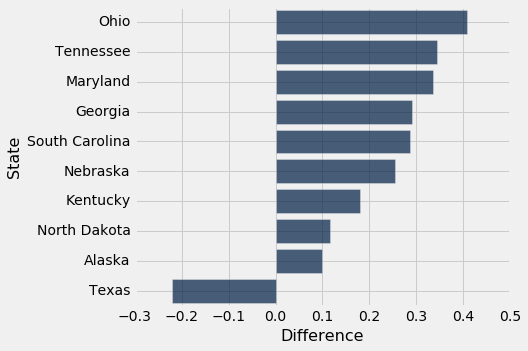

In [31]:
# this cell plots the differences in a bar graph, which makes it a bit easier to visualize
table_real_percents.sort('Difference', descending = True).barh('State','Difference')

Since all of the ten randomly selected states had statistically significant differences, nine of which are in the same direction, by my previously defined criteria, I have sufficient evidence to reject the null hypothesis. Thus, it is likely that there is some factor besides chance that causes the actual proportion of homicides with a non-white victim to be higher than expected.